## Read audio file

In [1]:
from tools.audio import read_audio, play_audio, \
    get_spectrogram, convert_to_db, get_complex_spectrogram, inverse_complex_spectrogram
import matplotlib.pyplot as plt

In [2]:
# Load audio file
filename = 'audio/1-9886-A-49.wav'
audio, sr = read_audio(filename)

torch.Size([1, 1103, 500]) torch.float32 tensor(9.3486e-13) tensor(102545.9141)


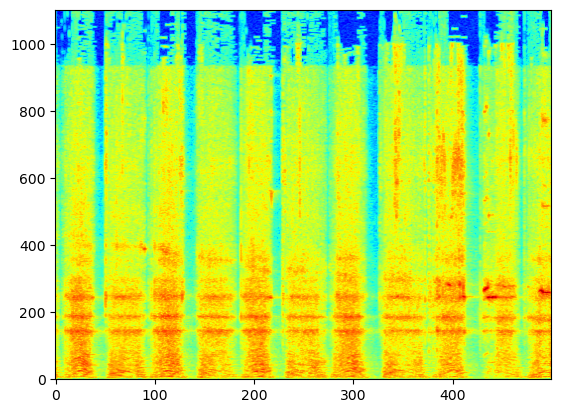

In [3]:
# Display spectrogram
spec = get_spectrogram(audio)
print(spec.shape, spec.dtype, spec.min(), spec.max())
spec_db = convert_to_db(spec)
plt.imshow(spec_db[0,:,:], origin='lower', cmap='jet', aspect='auto')
plt.show()

In [4]:
n_ftt = 2048

# Get complex spectrogram
cplx_spec = get_complex_spectrogram(audio, n_ftt=n_ftt)
print(cplx_spec.shape, cplx_spec.dtype)
# Reconstruct audio from spectrogram
audio_from_spec = inverse_complex_spectrogram(cplx_spec, n_ftt=n_ftt)


torch.Size([1, 1025, 501]) torch.complex64


In [5]:
# play_audio(audio, sr)

In [6]:
# play_audio(audio_from_spec, sr)

## Masking audio in frequency space

In [7]:
from tools.masking import create_masks, apply_masks

In [8]:
n_ftt = 2048

# Get complex spectrogram
cplx_spec = get_complex_spectrogram(audio, n_ftt=n_ftt)
print(cplx_spec.shape, cplx_spec.dtype)

# Construct masks
spec_shape = cplx_spec.shape[1:3]
n_masks, n_freq, n_time, p = 100, 40, 25, 0.5
masks = create_masks(spec_shape, n_masks, n_freq, n_time, p=p)
print(masks.shape, masks.dtype)

# Apply masks
masked_spec = apply_masks(cplx_spec, masks)
print(masked_spec.shape, masked_spec.dtype)

torch.Size([1, 1025, 501]) torch.complex64
torch.Size([100, 1025, 501]) torch.bool
torch.Size([100, 1025, 501]) torch.complex64


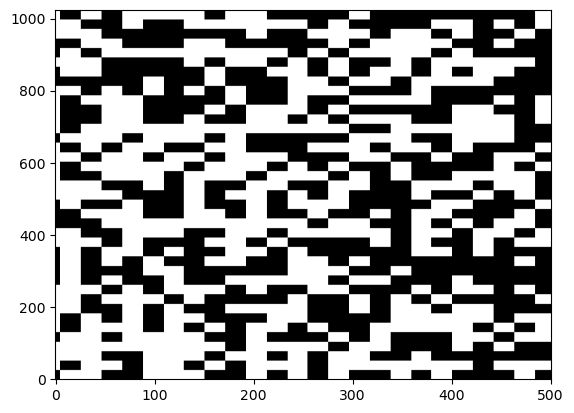

In [9]:
# Display first mask
first_mask = masks[1].numpy()

plt.imshow(first_mask, origin='lower', cmap='gray', aspect='auto')
plt.show()

In [10]:
masked_audios = inverse_complex_spectrogram(masked_spec, n_ftt=n_ftt)
print(masked_audios.shape, masked_audios.dtype)

torch.Size([100, 220500]) torch.float32


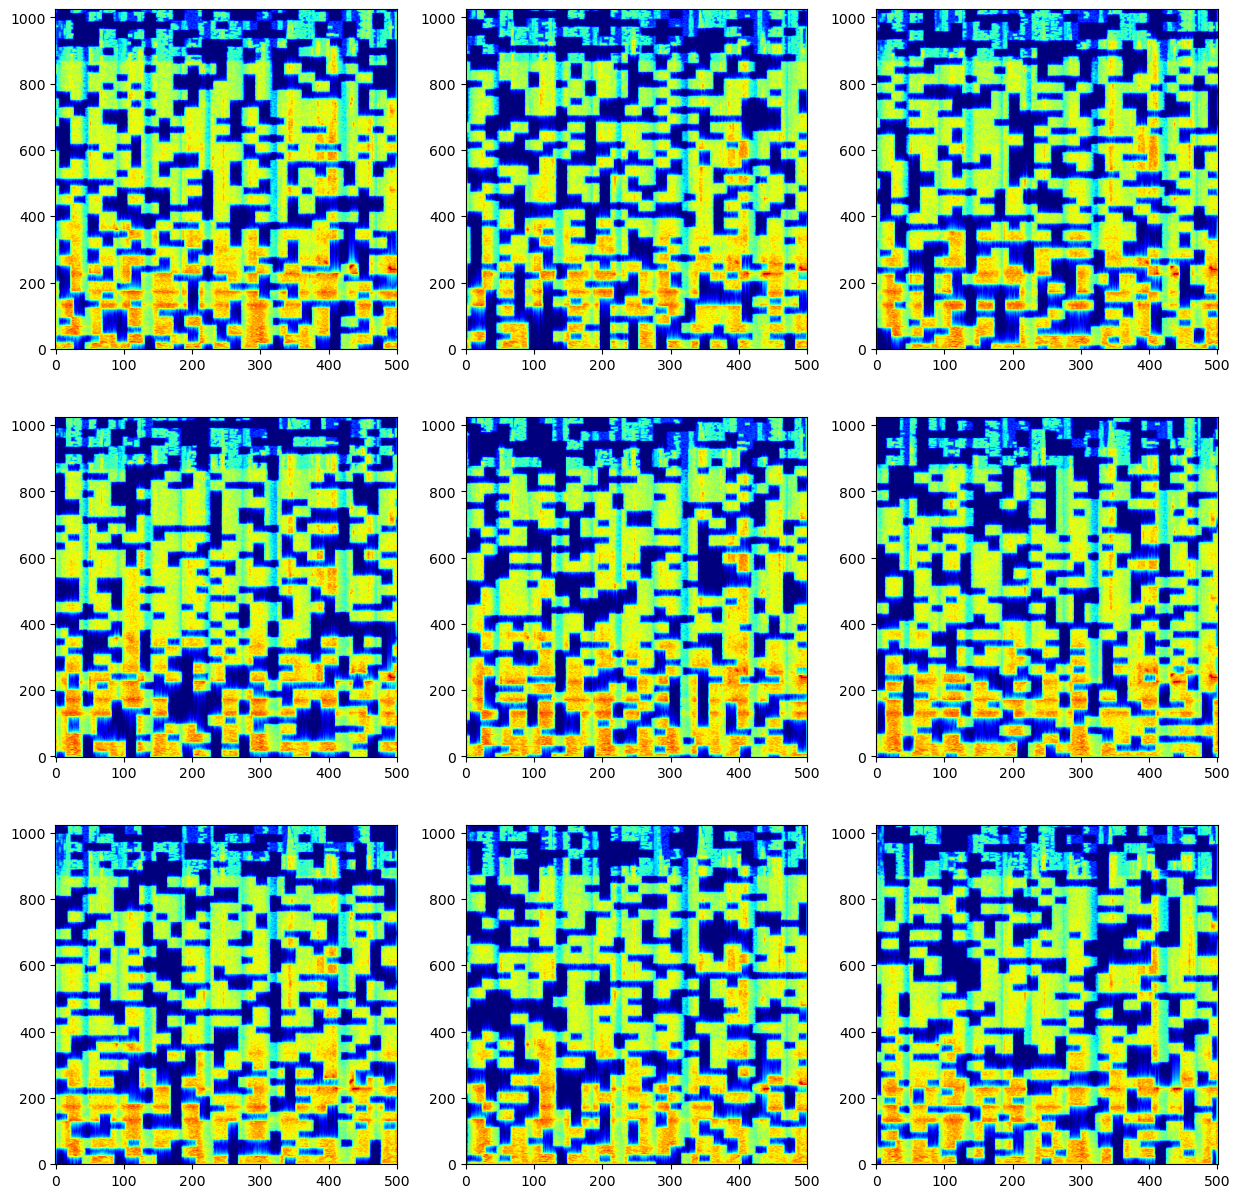

In [11]:
# Create and show masked spectrograms
plt.figure(figsize=(15,15))
for i in range(9):
    tmp_spec = get_spectrogram(masked_audios[i], n_ftt=n_ftt)
    tmp_spec_db = convert_to_db(tmp_spec)
    plt.subplot(3,3,i+1)
    plt.imshow(tmp_spec_db, origin='lower', cmap='jet', aspect='auto')
plt.show()


In [12]:
# Play masked audio
ix_audio = 20
# play_audio(masked_audios[ix_audio], sr)

## Get features with BEATS

In [13]:
from tools.audio import resample_audio
from prediction import load_beats_model

In [19]:
masks.int().shape, audio.shape, 1025*501

(torch.Size([100, 1025, 501]), torch.Size([1, 220500]), 513525)

In [26]:
# Resample audio for the BEATS model
res_audio = resample_audio(audio, sr, 16000)
res_masked_audios = resample_audio(masked_audios, sr, 16000)

In [27]:
import torch
masked_audio_inputs = torch.reshape(res_masked_audios, (n_masks, 1, res_masked_audios.shape[1]))

In [28]:
# clean up outputs from warnings
import warnings
warnings.filterwarnings("ignore")

# Load BEATS model
model_path = 'beats_env/BEATs_iter3_plus_AS2M_finetuned_on_AS2M_cpt2.pt'
beats_model = load_beats_model(model_path)

# Extract features of the original audio
_, _, h  = beats_model.extract_features(res_audio)
h_star = h.expand(n_masks, -1)
h_star.shape, h.shape


(torch.Size([100, 527]), torch.Size([1, 527]))

In [30]:
# Compute cosine similarity between original and masked features
import torch
from torch.nn.functional import cosine_similarity as cosine_sim
pdist = lambda o, m: cosine_sim(o, m)
inp_shape = 527
with torch.no_grad():
    W = torch.randn(tuple(masks.shape))
    R = torch.zeros(tuple(masks.shape))
    U = torch.zeros(tuple(masks.shape))
    for mask_idx, x_masked in enumerate(masked_audio_inputs):
        raw_mask = masks[mask_idx].int()
        W += raw_mask
        _, _, h_mask = beats_model.extract_features(x_masked)
        s = cosine_sim(h, h_mask)
        R_prev = R
        R += masks * (s - R) / W
        U += (s - R) * (s - R_prev) * raw_mask
R, U/(W-1)

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0., 

(tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.9643, 0.9651, 0.9626],
          [0.0000, 0.0000, 0.0000,  ..., 0.9642, 0.9644, 0.9643],
          [0.0000, 0.0000, 0.0000,  ..., 0.9643, 0.9642, 0.9649]],
 
         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
 
         [[0.9589, 0.9644, 0.9645,  ..., 0.9701, 0.9619, 0.9669],
          [0.9689, 0.9187, 0.9644,  ..., 0.9655, 0.9637, 0.9644],
          [0.9635, 0.9655, 0.9613,  ...,

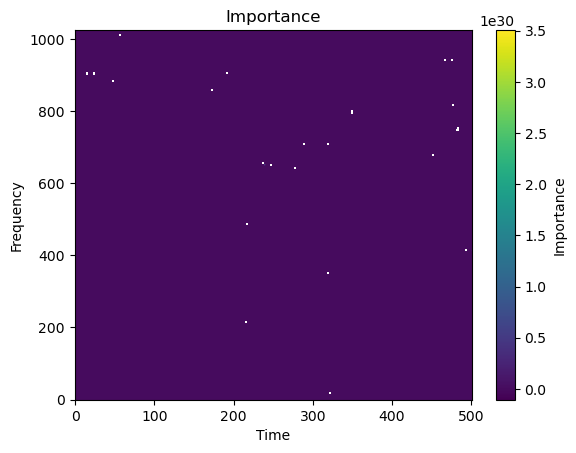

In [45]:
mean = torch.mean(R, dim=0)
mean.shape
plt.imshow(mean, aspect='auto', cmap='viridis', origin='lower')
plt.colorbar(label='Importance')
plt.title('Importance')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.show()

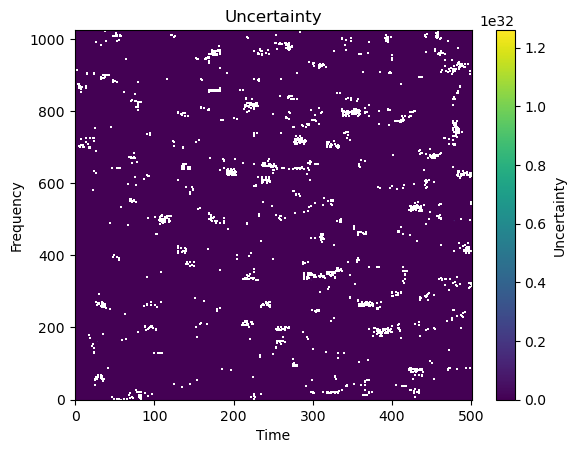

In [46]:
mean = torch.mean(U/(W-1), dim=0)
mean.shape
plt.imshow(mean, aspect='auto', cmap='viridis', origin='lower')
plt.colorbar(label='Uncertainty')
plt.title('Uncertainty')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.show()

torch.Size([1]) torch.float32


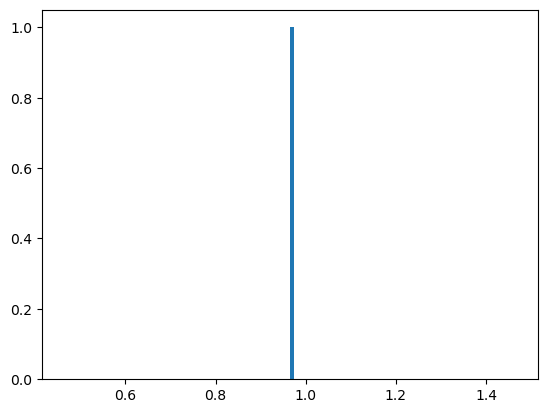

In [50]:
# Compute cosine similarity between original and masked features
from torch.nn.functional import cosine_similarity as cosine_sim
# Extract features of the masked audios
_, _, m_logits = beats_model.extract_features(masked_audio_inputs[0])

# Compute cosine similarity
cos_sim = cosine_sim(h, m_logits)
print(cos_sim.shape, cos_sim.dtype)
# Display similarity histogram
plt.hist(cos_sim.detach().numpy(), bins=100)
plt.show()
